# Introduction #

In the tutorial, we learned about the architecture of a typical convolutional base used for feature extraction. We saw how we can define our own blocks by subclassing the Keras `Layer` class. We can then use these blocks in a model just like we do any other layer.

In our implementation of the convolutional block, we only allowed for a single convolutional layer. However, most modern convnets will stack several convolutional layers together before applying the pooling. In these exercises, you'll address this shortcoming by extending our implementation.

Get started by running the code cell below.

In [ ]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex2 import *

# Imports
import visiontools
from visiontools import StanfordCars
import tensorflow as tf
import tensorflow_datasets as tfds

# Load training and validation sets
DATA_DIR = '/kaggle/input/stanford-cars-for-learn/'
(ds_train, ds_valid), ds_info = tfds.load('stanford_cars/simple',
                                          split=['train', 'test'],
                                          shuffle_files=True,
                                          with_info=True,
                                          data_dir=DATA_DIR)
print(("Loaded {} training examples " +
       "and {} validation examples " +
       "with classes {}.").format(
           ds_info.splits['train'].num_examples,
           ds_info.splits['test'].num_examples,
           ds_info.features['label'].names))

# Create data pipeline
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
SIZE = [192, 192]
preprocess = visiontools.make_preprocessor(size=SIZE)

ds_train_ = (ds_train.map(preprocess)
            .cache()
            .shuffle(ds_info.splits['train'].num_examples,
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

ds_valid_ = (ds_valid.map(preprocess)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

### 1) Extend Convolutional Block

Here is a diagram of the model we want to implement:

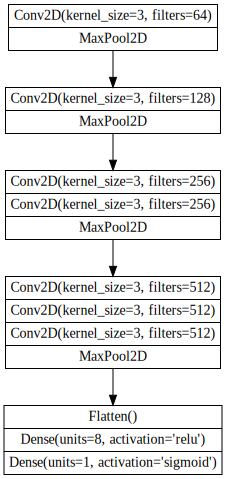

In [60]:
#$HIDE$
# TODO: Replace with image
from graphviz import Digraph

def cb(layers):
    label = '{'
    for k, f in layers:
        label += 'Conv2D(kernel_size={}, filters={}) |'.format(k, f)
    label += 'MaxPool2D}'
    return label

m = Digraph('conv_model', node_attr={'shape': 'record'})
m.node('block1', label=cb([(3, 64)]))
m.node('block2', label=cb([(3, 128)]))
m.node('block3', label=cb([(3, 256), (3, 256)]))
m.node('block4', label=cb([(3, 512), (3, 512), (3, 512)]))
m.node('head', label="{Flatten() | Dense(units=8, activation='relu') | Dense(units=1, activation='sigmoid')}")
m.edges([('block1', 'block2'), ('block2', 'block3'), ('block3', 'block4'), ('block4', 'head')])

m

Notice that some of the convolutional blocks have more than one convolutional layer. Extend the definition of `ConvolutionalBlock` to handle these kinds of blocks -- that is, each block should be able to contain an arbitrary number of convolutional layers prior to the pooling layer. The `filters` argument this time should be a list like `[128, 128]`.

In [ ]:
import tensorflow.keras.layers as layers

class ConvolutionalBlock(layers.Layer):
    
    # Instantiate the layers
    def __init__(self, kernel_size, filters):
        super().__init__()
        
        # Convolutional Layers
        self.conv_layers = []

        # YOUR CODE HERE: Build a list of convolutional layers
        ----

        # Pooling Layer
        self.pool = layers.MaxPool2D(pool_size=2)
                
    # Build the layers once the shape of the inputs is known
    def call(self, inputs):
        x = inputs
        for conv in self.conv_layers:
            x = conv(x)
        x = self.pool(x)
        return x

q_1.check()

In [ ]:
# TODO: q_1 unit test
q_1.assert_check_passed()

In [ ]:
# Lines below will give you a hint or solution code
#_COMMENT_IF(PROD)_
q_1.hint()
#_COMMENT_IF(PROD)_
q_1.solution()

In [ ]:
import tensorflow.keras.layers as layers

class ConvolutionalBlock(layers.Layer):
    
    # Instantiate the layers
    def __init__(self, kernel_size, filters):
        super().__init__()
        
        # Convolutional Layers
        self.conv_layers = []
        for f in filters:
            self.conv_layers.append(
                layers.Conv2D(kernel_size=kernel_size, 
                              filters=f,
                              activation='relu',
                              padding='same')
            )
                # Pooling Layer
        self.pool = layers.MaxPool2D(pool_size=2)
                
    # Build the layers once the shape of the inputs is known
    def call(self, inputs):
        x = inputs
        for conv in self.conv_layers:
            x = conv(x)
        x = self.pool(x)
        return x

### 2) Define Model

Now create the model using the `ConvolutionalBlock` class you just defined. Remember to refer back to the diagram above to get the correct number of layers.

In [ ]:
from tensorflow.keras import Sequential

model = Sequential([
    # YOUR CODE HERE: Use ConvolutionalBlock to build the model
    # indicated in the diagram at the start of the page.
    ----
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
q_2.check()

In [ ]:
from tensorflow.keras import Sequential

model = Sequential([
    ConvolutionalBlock(kernel_size=3, filters=[64]),
    ConvolutionalBlock(kernel_size=3, filters=[128]),
    ConvolutionalBlock(kernel_size=3, filters=[256, 256]),
    ConvolutionalBlock(kernel_size=3, filters=[512, 512, 512]),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
q_2.assert_check_passed()

In [ ]:
# Lines below will give you a hint or solution code
#_COMMENT_IF(PROD)_
q_2.hint()
#_COMMENT_IF(PROD)_
q_2.solution()

### 3) Train

Finally, let's run the training loop. Just run the cell below to get credit.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

STEPS = ds_info.splits['train'].num_examples // BATCH_SIZE
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=30,
    callbacks=[early_stopping],
)
q_3.check()

You should have gotten around 90% validation accuracy for this model. This is almost as good as the transfer learning model from Lesson 1! With more modification, it's likely you could do even better.

### 4) Compare to the Transfer Learning Models

Our dataset is fairly large for a simple binary classification problem. For this reason, we were able to build a custom neural network that's competitive with the much larger transfer learning models from the previous lesson.

The model from Lesson 1 however was trained on a much larger dataset and contains many more layers. Why do you think your smaller model was able to do just as well?

After you've considered your answer, run the following cell.

In [ ]:
# View the solution (Run this code cell to receive credit!)
q_4.solution()